In [151]:
import pandas as pd
import os
import sys
from collections import defaultdict
from pathlib import Path
import numpy as np
import json
import ipdb
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

hoops_dir = Path("/Users/danielfriedman/Desktop/hoops")
data_dir = hoops_dir / "data"
sys.path.append(hoops_dir.as_posix())

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 30)

from pipeline import team_metadata, score_by_score, rank, playstats, merge

In [152]:
def plot(w=9, h=6):
    return plt.subplots(figsize=(w, h))

In [159]:
first_season = "2011-12"
last_season = "2021-22"
importlib.reload(merge)
m = merge.merge(first_season, last_season)


#### Empirical Means

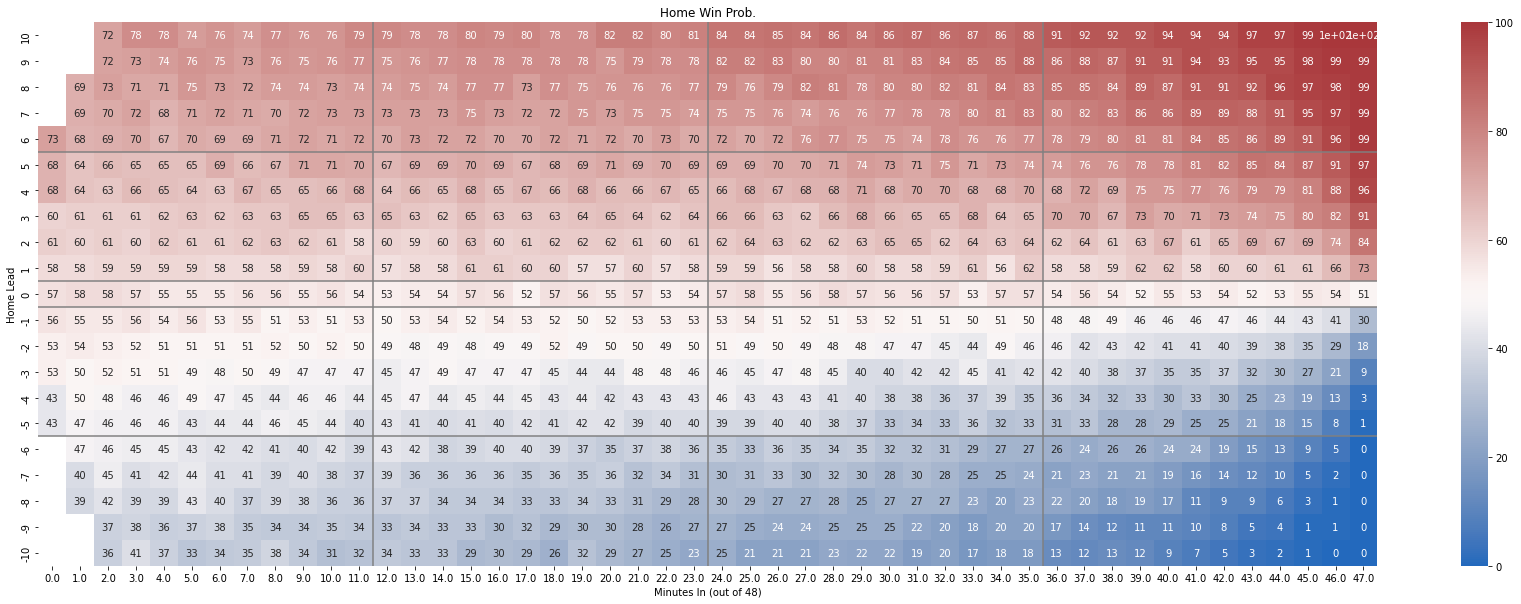

In [160]:
time_mod = 1
score_mod = 1

x = m.drop_duplicates(subset=['game_id', 'mins', 'home_lead']).groupby(["mins", "home_lead"]).agg({'home_win': ['count', 'mean']})['home_win'].reset_index().rename(columns={'mean':'win_pct'})
x['win_pct'] = (x['win_pct'] * 100).astype(int)
x = x.loc[x['count'] >= 50]
x = x.pivot(index='home_lead', columns='mins', values='win_pct')
x.index = np.array(list(x.index)) * score_mod
x.columns = np.array(list(x.columns)) * time_mod

fig, ax = plt.subplots(figsize=(30, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
ax.axhline(10, color='gray')
ax.axhline(11, color='gray')
ax.axhline(5, color='gray')
ax.axhline(16, color='gray')
sns.heatmap(x.loc[10:-10:-1, 0:47], annot=True, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Home Win Prob.");



___

# FFNN

In [240]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Activation
from sklearn.preprocessing import StandardScaler


In [264]:
def score_model(m, features, layer_sizes, initializer_std=5, lr=1e-6, patience=3, batch_size=32, cutoff="2021-09-01"):
    
    ## Get data
    m_ = m.loc[m['time'] < 48].dropna(axis=0).reset_index(drop=True).copy(deep=True)
    m_['time_left'] = np.log(48-m_['time'])
    m_['home_lead_pml'] = m_['home_lead'] / np.sqrt(48-m_['time'])
    X_train = m_.loc[m_['date'] <= cutoff, features].to_numpy()
    X_test = m_.loc[m_['date'] > cutoff, features].to_numpy()
    y_train = m_.loc[m_['date'] <= cutoff, 'home_win'].astype(int).to_numpy()
    y_test = m_.loc[m_['date'] > cutoff, 'home_win'].astype(int).to_numpy()
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
    ## Model
    # Construct
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_train_scaled.shape[1],)))
    for layer_size in layer_sizes:
        initializer = keras.initializers.RandomNormal(mean=0.0, stddev=initializer_std/100, seed=None)
        model.add(layers.Dense(layer_size, activation="relu", kernel_initializer=initializer))    
    model.add(layers.Dense(1, activation='sigmoid'))
    print(model.summary())
    # Compile
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
    # Fit
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=batch_size,
        epochs=500,
        validation_data=(X_test_scaled, y_test),
        callbacks=[callback],
        verbose=2
    )
    # Score
    score = history.history['val_loss'][-1]
    
    # ## Write out
    # name = "_".join([str(size) for size in layer_sizes]) + "|" + str(initializer_std) + "|" + str(patience) +  "|" + str(lr) + "|" + "_".join(features)
    # details = {'features': features, 'layer_sizes': layer_sizes, 'score': score}
    # with open(f"model/scores/{name}.json", 'w') as f:
    #     json.dump(details, f)
        
    ## Return model
    return model, history, ss


In [265]:
## Get features
features = ['home_lead', 'time_left', 'ppm', 'home_ranking', 'vis_ranking', 'home_lead_pml']
layer_sizes = [16, 32, 8]
initializer_std=2
patience=3
lr=2.5e-6
batch_size=64
cutoff="2021-09-01"
model, history, ss = score_model(m, features, layer_sizes, initializer_std, lr, patience, batch_size, cutoff)


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 16)                112       
_________________________________________________________________
dense_85 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_86 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 9         
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
20127/20127 - 9s - loss: 0.6774 - acc: 0.6937 - val_loss: 0.6480 - val_acc: 0.7550
Epoch 2/500
20127/20127 - 8s - loss: 0.5872 - acc: 0.7635 - val_loss: 0.5348 - val_acc: 0.7566
Epoch 3/500
20127/20127 - 8s - loss: 0.4900 - acc: 0.7652 

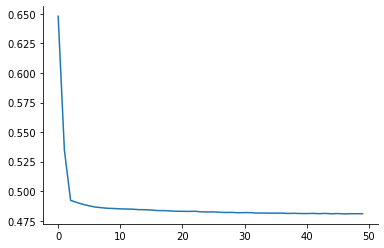

In [266]:
i=0
sns.lineplot(x=np.arange(len(history.history['val_loss'][-i:])), y=history.history['val_loss'][-i:])
sns.despine()

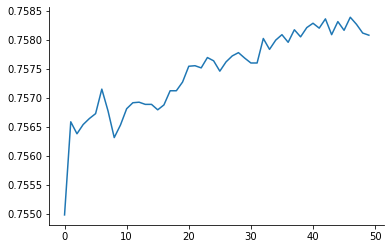

In [267]:
sns.lineplot(x=np.arange(len(history.history['val_acc'])), y=history.history['val_acc'])
sns.despine()

In [268]:
def get_win_probs_by_game_state(model, features, m, ss, home_ranking=0, vis_ranking=0, mins=np.arange(0, 48), home_leads=np.arange(-10, 11), mean_replacers=None):
    m_ = m.loc[m['time'] < 48].dropna(axis=0).reset_index(drop=True).copy(deep=True)
    n_combos = len(mins)*len(home_leads)
    mean_replacers = mean_replacers if mean_replacers is not None else dict()
    dummy_features = [f for f in features if f in m.columns]
    dummy_row = pd.DataFrame(m[dummy_features].mean()).T
    for feature, value in mean_replacers.items():
        dummy_row.loc[0, feature] = value
    dummy_data = pd.concat([dummy_row]*n_combos).reset_index(drop=True)
    time = np.tile(mins, len(home_leads))
    dummy_data['time_left'] = np.log(48-time)
    dummy_data['home_lead'] = np.repeat(home_leads, len(mins))
    dummy_data['home_lead_pml'] = dummy_data['home_lead']/np.sqrt(48-time)
    dummy_data['home_ranking'] = home_ranking
    dummy_data['vis_ranking'] = vis_ranking
    dummy_data_scaled = ss.transform(dummy_data[features].to_numpy())
    dummy_data['yhat'] = model.predict(dummy_data_scaled)[:,0]
    dummy_data['time'] = time
    panel = dummy_data.pivot(index='home_lead', columns='time', values='yhat')
    return panel


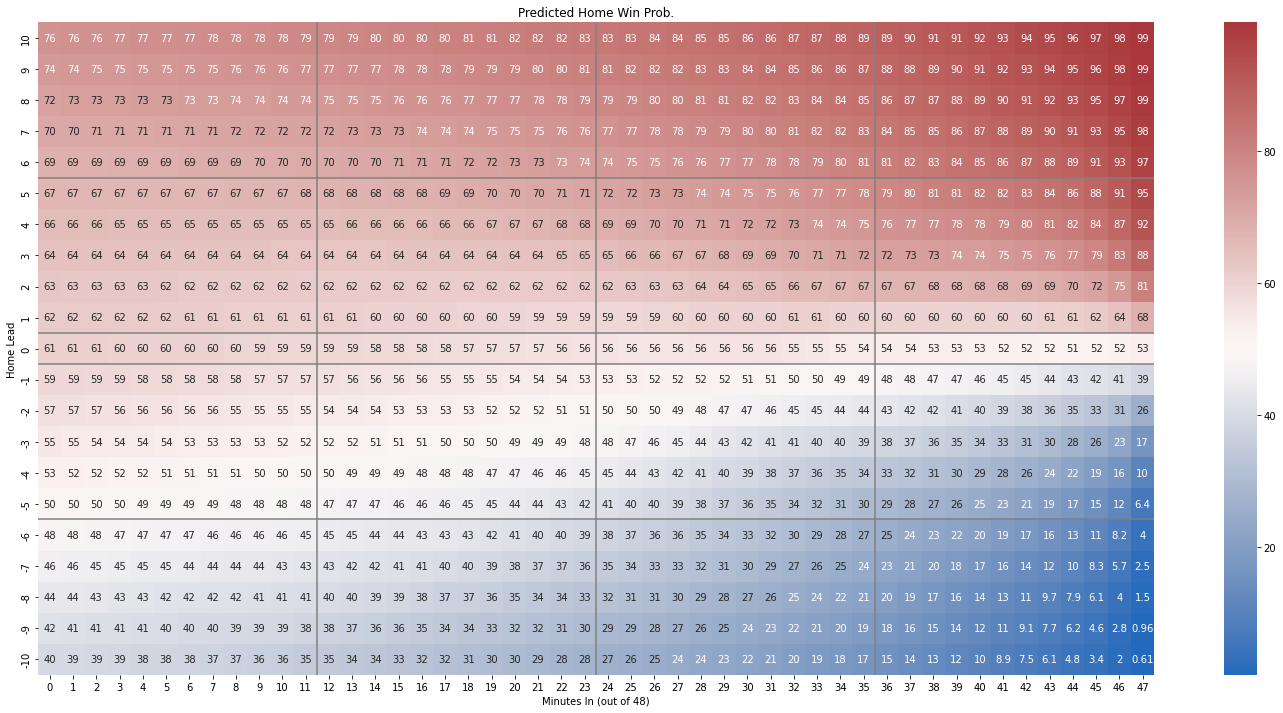

In [269]:
# Get win probs
panel_even = get_win_probs_by_game_state(model, features, m, ss)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_even[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_even[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


<AxesSubplot:xlabel='home_lead'>

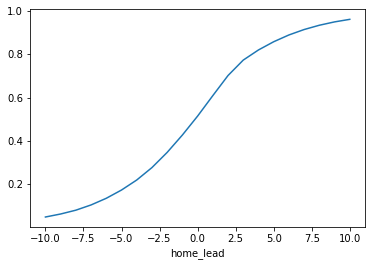

In [270]:
sns.lineplot(x=panel_even[44].index, y=panel_even[44].values)

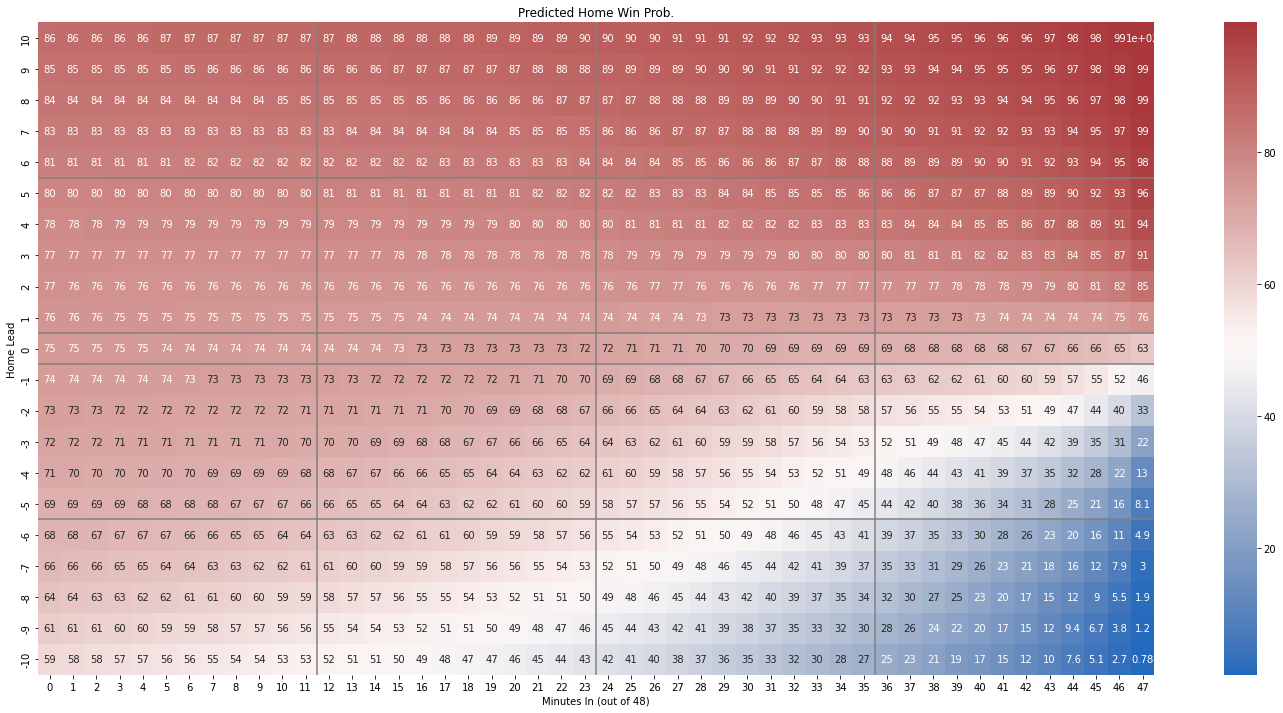

In [271]:
# Get win probs
panel_home_fav = get_win_probs_by_game_state(model, features, m, ss, home_ranking=.5, vis_ranking=-.5)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_home_fav[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_home_fav[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


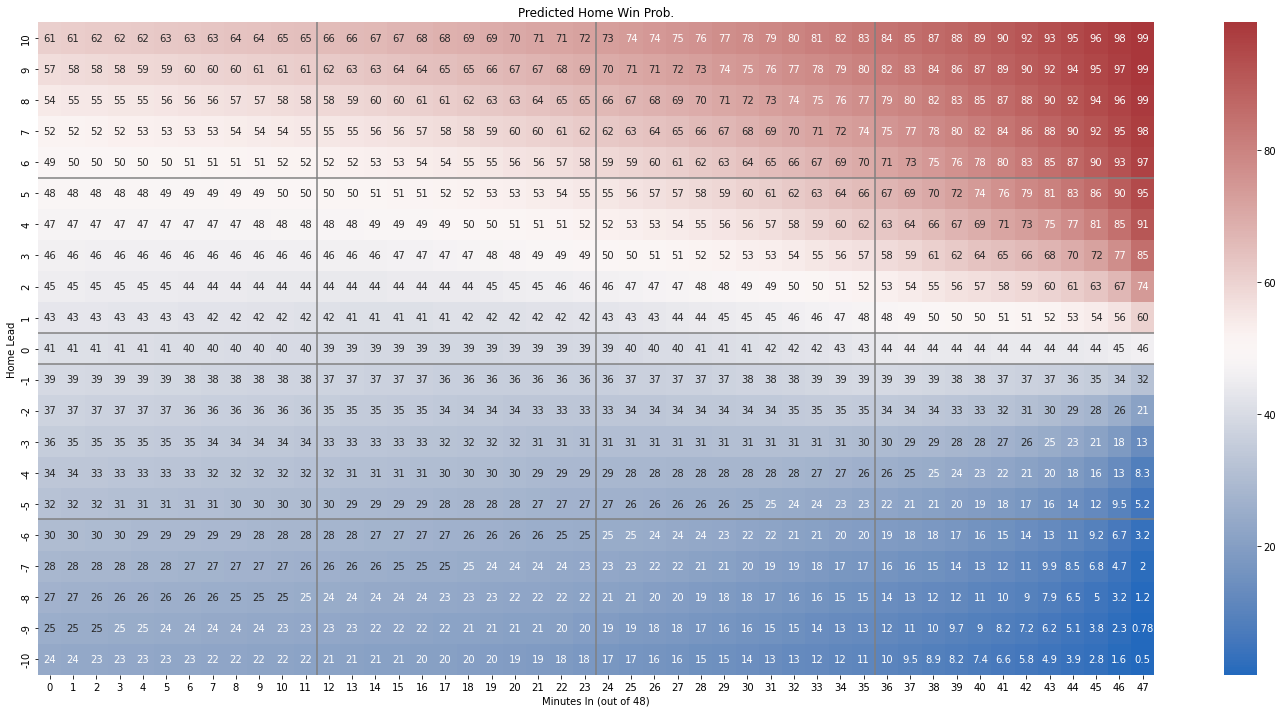

In [272]:
# Get win probs
panel_vis_fav = get_win_probs_by_game_state(model, features, m, ss, home_ranking=-.5, vis_ranking=.5)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_vis_fav[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_vis_fav[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


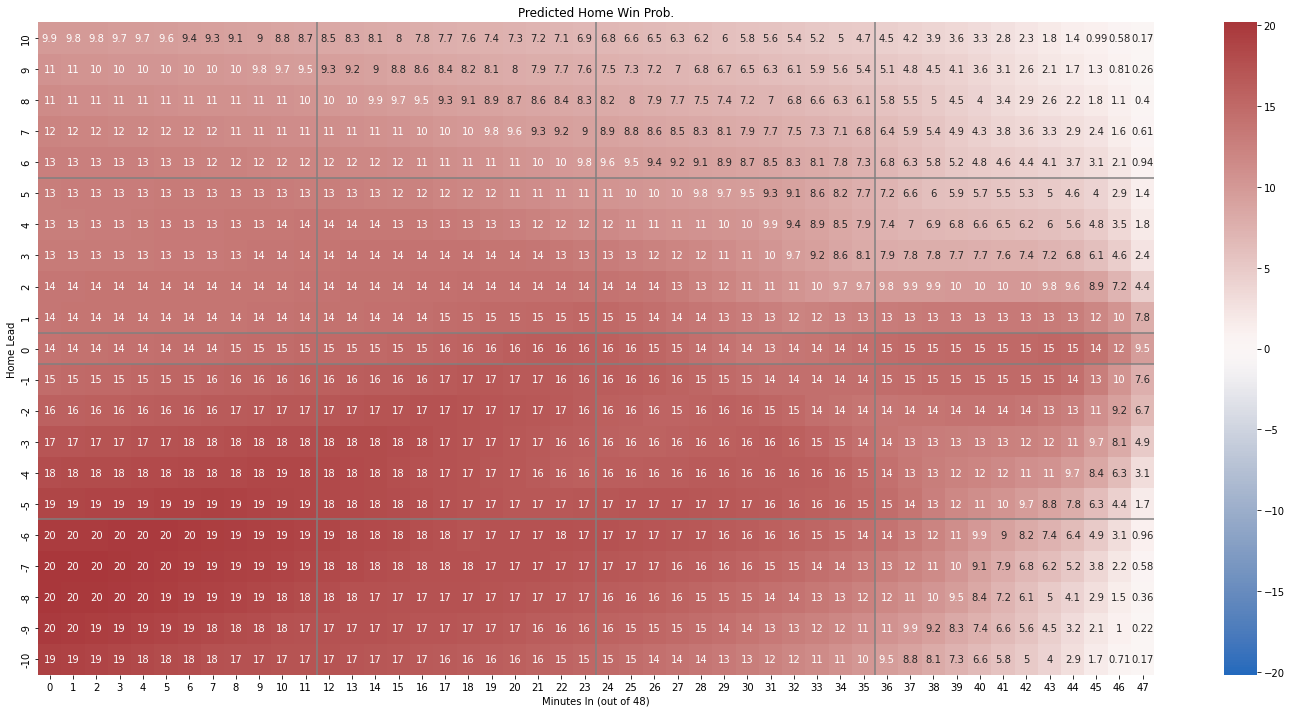

In [273]:
# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
panel_diff = (panel_home_fav[::-1] - panel_even[::-1])*100
vmax = max(-panel_diff.min().min(), panel_diff.max().max())
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_diff, annot=True, cmap="vlag", vmin=-vmax, vmax=vmax)
else:
    sns.heatmap(panel_diff, annot=False, cmap="vlag", vmin=-vmax, vmax=vmax)
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


____

In [179]:
sbs = pd.read_csv("data/score_by_score/2021-22.csv")
sbs.loc[sbs['date'] == "2022-03-03"].sample(5)

,game_id,date,home,vis,time,home_score,vis_score,home_win
102117,22100945,2022-03-03,LAC,LAL,33.93,98,70,True
95890,22100940,2022-03-03,BOS,MEM,27.55,61,53,True
95278,22100941,2022-03-03,BKN,MIA,14.25,37,27,False
70787,22100710,2022-03-03,ATL,CHI,9.08,24,28,True
89769,22100942,2022-03-03,TOR,DET,43.35,94,99,False


In [180]:
game_sbs = sbs.loc[sbs['game_id'] == 22100941]
game_sbs

,game_id,date,home,vis,time,home_score,vis_score,home_win
95244,22100941,2022-03-03,BKN,MIA,0.00,0,0,False
95245,22100941,2022-03-03,BKN,MIA,1.08,3,0,False
95246,22100941,2022-03-03,BKN,MIA,1.65,5,0,False
95247,22100941,2022-03-03,BKN,MIA,2.07,5,3,False
95248,22100941,2022-03-03,BKN,MIA,2.42,7,3,False
...,...,...,...,...,...,...,...,...
95359,22100941,2022-03-03,BKN,MIA,45.62,106,109,False
95360,22100941,2022-03-03,BKN,MIA,45.62,107,109,False
95361,22100941,2022-03-03,BKN,MIA,47.42,107,111,False
95362,22100941,2022-03-03,BKN,MIA,47.62,107,113,False


In [181]:
rbd = pd.read_csv("data/rankings/2021-22.csv")

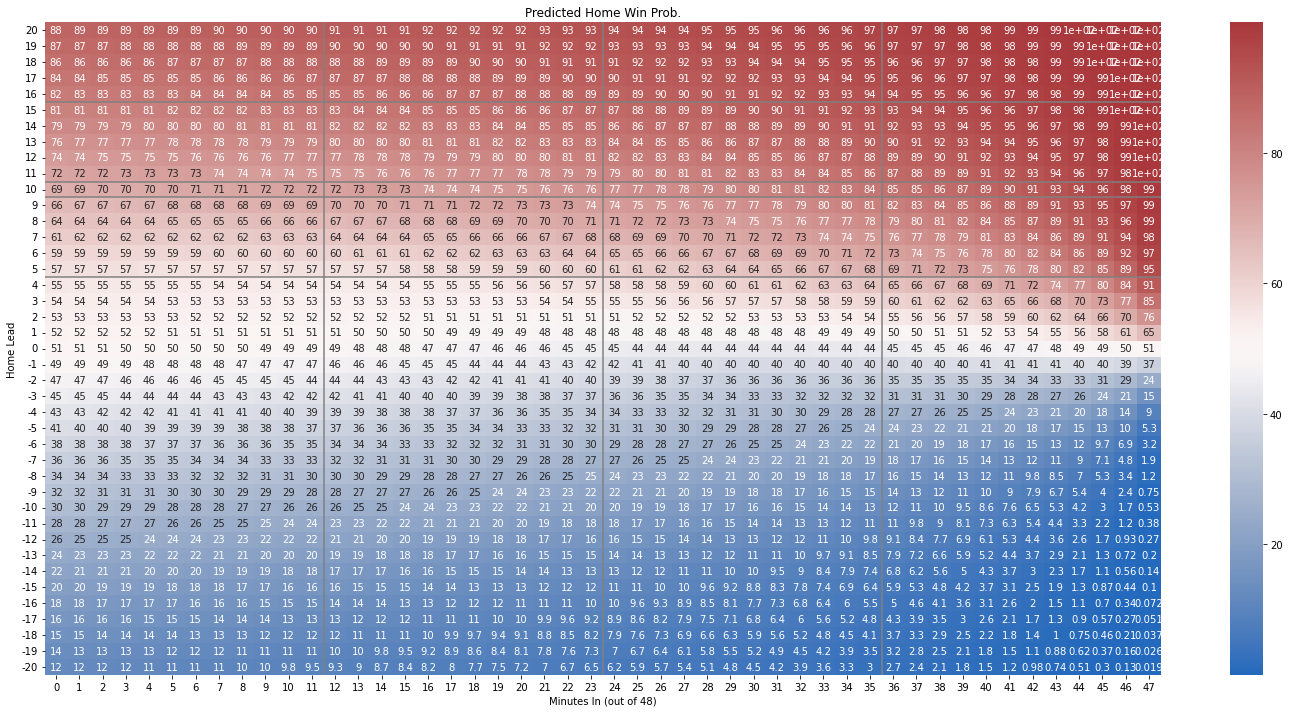

In [182]:
home = game_sbs.iloc[-1]['home']
vis = game_sbs.iloc[-1]['vis']
home_ranking = rbd.sort_values("date").groupby("team")['ranking'].last()[home]
vis_ranking = rbd.sort_values("date").groupby("team")['ranking'].last()[vis]
panel = get_win_probs_by_game_state(model, features, m, ss, home_ranking=home_ranking, vis_ranking=vis_ranking, home_leads=np.arange(-20, 21))

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
ax.axhline(10, color='gray')
ax.axhline(11, color='gray')
ax.axhline(5, color='gray')
ax.axhline(16, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");

In [183]:
game_sbs

,game_id,date,home,vis,time,home_score,vis_score,home_win
95244,22100941,2022-03-03,BKN,MIA,0.00,0,0,False
95245,22100941,2022-03-03,BKN,MIA,1.08,3,0,False
95246,22100941,2022-03-03,BKN,MIA,1.65,5,0,False
95247,22100941,2022-03-03,BKN,MIA,2.07,5,3,False
95248,22100941,2022-03-03,BKN,MIA,2.42,7,3,False
...,...,...,...,...,...,...,...,...
95359,22100941,2022-03-03,BKN,MIA,45.62,106,109,False
95360,22100941,2022-03-03,BKN,MIA,45.62,107,109,False
95361,22100941,2022-03-03,BKN,MIA,47.42,107,111,False
95362,22100941,2022-03-03,BKN,MIA,47.62,107,113,False


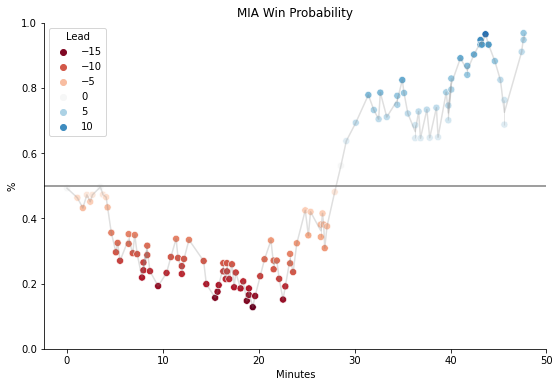

In [184]:
probs = list()
home_leads = list()
time = list()
for _, row in game_sbs.iterrows():
    probs.append(panel.loc[row['home_score']-row['vis_score'], np.floor(row['time'])])
    home_leads.append(row['home_score']-row['vis_score'])
    time.append(row['time'])

last_row = game_sbs.iloc[-1]
if last_row['home_score'] < last_row['vis_score']:
    probs = [1-prob for prob in probs]
    leads = [-home_lead for home_lead in home_leads]
    winner = last_row['vis']
else:
    leads = home_leads
    winner = last_row['home']

fig, ax = plt.subplots(figsize=(9, 6))
max_lead = max(-min(leads), max(leads))
sns.scatterplot(x=time, y=probs, hue=leads, palette="RdBu", hue_norm=(-max_lead, max_lead), s=50)
sns.lineplot(x=time, y=probs, color="gray", alpha=0.25) 
ax.axhline(0.5, color='gray')
ax.set_ylim(0, 1)
plt.legend(title=f"Lead")
ax.set(xlabel="Minutes", ylabel="%", title=f"{winner} Win Probability")
sns.despine()
